### Name: 陳昱丞
### Student ID: 0716206

In [40]:
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 15 13:59:40 2020

@author: user
"""

import pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn import tree  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap

### Data input, then shuffle

In [41]:
student = pandas.read_csv("student-mat.csv",header=0,delimiter=";")

student = shuffle(student) #shuffle data

因為文章說G1和G2有很大的關係，捨棄他們會讓預測更有用，因此我選擇捨棄這兩個feature。
原文:
The target attribute G3 has a strong correlation with attributes G2 and G1. 
This occurs because G3 is the final year grade (issued at the 3rd period), 
while G1 and G2 correspond to the 1st and 2nd period grades. 
It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful.

In [42]:
student = student.drop(columns=["G1","G2"]) #model1: 2 classes
student2 = student #model2: 5 classes

### Data preprocessing

用G3進行題目指示的兩種分類。再用label encoder和fit transform標準化資料，再轉成np array方便處理。

In [43]:
student_class=[]
student2_class=[]
for i in range(395):
    if student.iloc[i]["G3"] >= 10:
        student_class.append(1) #pass
    else:
        student_class.append(0) #fail
    
    if 0 <= student2.iloc[i]["G3"] <= 9:
        student2_class.append(0) #F
    elif 10 <= student2.iloc[i]["G3"] <= 11:
        student2_class.append(1) #D
    elif 12 <= student2.iloc[i]["G3"] <= 13:
        student2_class.append(2) #C
    elif 14 <= student2.iloc[i]["G3"] <= 15:
        student2_class.append(3) #B
    elif 16 <= student2.iloc[i]["G3"] <= 20:
        student2_class.append(4) #A
    
student_class = np.array(student_class)
student2_class = np.array(student2_class)

for i in student.columns:
    student[i] = LabelEncoder().fit_transform(student[i])
stu = student.drop(columns=["G3"]).columns
student = student.drop(columns=["G3"]).to_numpy()

for i in student2.columns:
    student2[i] = LabelEncoder().fit_transform(student2[i])
stu2 = student2.drop(columns=["G3"]).columns
student2 = student2.drop(columns=["G3"]).to_numpy()

k-fold cross-validation(k=3)的函式。先寫好方便底下呼叫。

In [44]:
def kfold_class1(model):
    print("\nk-fold class 1:")
    student_ascores = model_selection.cross_val_score(model, student, student_class, cv=3, scoring="accuracy")
    student_pscores = model_selection.cross_val_score(model, student, student_class, cv=3, scoring="precision")
    student_rscores = model_selection.cross_val_score(model, student, student_class, cv=3, scoring="recall")
    print("k_fold Accuracy:", student_ascores.mean())
    print("k_fold Precision:", student_pscores.mean())
    print("k_fold Recall:", student_rscores.mean())
    
    
def kfold_class2(model):
    print("\nk-fold class 2:")
    student2_ascores = model_selection.cross_val_score(model, student2, student2_class, cv=3, scoring="accuracy")
    student2_pscores = model_selection.cross_val_score(model, student2, student2_class, cv=3, scoring="precision_micro")
    student2_rscores = model_selection.cross_val_score(model, student2, student2_class, cv=3, scoring="recall_micro")
    print("k_fold Accuracy:", student2_ascores.mean())
    print("k_fold Precision:", student2_pscores.mean())
    print("k_fold Recall:", student2_rscores.mean())

### Model Construction

Decision Tree的部分。先holdout validation把他split成7:3，再放入DecisionTreeClassifier。兩種task分開做。之後把畫好的tree存成檔案。

In [45]:
print("Decision Tree:")
#class 1: 2 classes
X_train,X_test,Y_train,Y_test=model_selection.train_test_split(student,student_class,test_size=0.3) #split 7:3


clf = tree.DecisionTreeClassifier(criterion='entropy')  
clf = clf.fit(X_train,Y_train)
prediction = clf.predict(X_test)

# Visualize model
with open("result", 'w') as f:  
    f = tree.export_graphviz(clf, feature_names=stu, out_file=f)
    
    
#class 2: 5 classes
X2_train,X2_test,Y2_train,Y2_test=model_selection.train_test_split(student2,student2_class,test_size=0.3) #split 7:3

clf2 = tree.DecisionTreeClassifier(criterion='entropy')  
clf2 = clf2.fit(X2_train,Y2_train)
prediction2 = clf2.predict(X2_test)

# Visualize model
with open("result2", 'w') as f:  
    f = tree.export_graphviz(clf2, feature_names=stu2, out_file=f)

Decision Tree:


confusion matrix呼叫套件函式、k-fold呼叫上方寫好的函式。

In [46]:
#confusion matrix class 1
print("\nconfusion matrix 1st(2 classes):")
print(confusion_matrix(Y_test, prediction))

#confusion matrix class 2
print("\nconfusion matrix 2nd(5 classes):")
print(confusion_matrix(Y2_test, prediction2))

#k-fold class 1
kfold_class1(clf)

#k-fold class 2
kfold_class2(clf2)


confusion matrix 1st(2 classes):
[[25 15]
 [22 57]]

confusion matrix 2nd(5 classes):
[[23 12  4  3  3]
 [ 7 10  8  5  1]
 [ 8  6  5  1  0]
 [ 7  4  0  3  2]
 [ 1  2  1  2  1]]

k-fold class 1:
k_fold Accuracy: 0.6379307046241558
k_fold Precision: 0.7163461538461539
k_fold Recall: 0.7205907388491658

k-fold class 2:
k_fold Accuracy: 0.275797465987736
k_fold Precision: 0.2833153667949156
k_fold Recall: 0.2833545133989477


Random Forest的部分。一樣把資料放進函式。這裡要做3種不同的number of trees。我選n=5,10,20。

In [47]:
print("\nRandom Forest (n=5):")
rf = RandomForestClassifier(n_estimators=5)
rf = rf.fit(X_train,Y_train)
prediction_rf = rf.predict(X_test)
print("\nconfusion matrix 1st(2 classes):")
print(confusion_matrix(Y_test, prediction_rf))
kfold_class1(rf)

rf2 = RandomForestClassifier(n_estimators=5)
rf2 = rf2.fit(X2_train,Y2_train)
prediction2_rf = rf2.predict(X2_test)
print("\nconfusion matrix 2nd(5 classes):")
print(confusion_matrix(Y2_test, prediction2_rf))
kfold_class2(rf2)

print("\nRandom Forest (n=10):")
rf = RandomForestClassifier(n_estimators=10)
rf = rf.fit(X_train,Y_train)
prediction_rf = rf.predict(X_test)
print("\nconfusion matrix 1st(2 classes):")
print(confusion_matrix(Y_test, prediction_rf))
kfold_class1(rf)

rf2 = RandomForestClassifier(n_estimators=10)
rf2 = rf2.fit(X2_train,Y2_train)
prediction2_rf = rf2.predict(X2_test)
print("\nconfusion matrix 2nd(5 classes):")
print(confusion_matrix(Y2_test, prediction2_rf))
kfold_class2(rf2)

print("\nRandom Forest (n=20):")
rf = RandomForestClassifier(n_estimators=20)
rf = rf.fit(X_train,Y_train)
prediction_rf = rf.predict(X_test)
print("\nconfusion matrix 1st(2 classes):")
print(confusion_matrix(Y_test, prediction_rf))
kfold_class1(rf)

rf2 = RandomForestClassifier(n_estimators=20)
rf2 = rf2.fit(X2_train,Y2_train)
prediction2_rf = rf2.predict(X2_test)
print("\nconfusion matrix 2nd(5 classes):")
print(confusion_matrix(Y2_test, prediction2_rf))
kfold_class2(rf2)


Random Forest (n=5):

confusion matrix 1st(2 classes):
[[15 25]
 [11 68]]

k-fold class 1:
k_fold Accuracy: 0.6734010599016625
k_fold Precision: 0.732822214322392
k_fold Recall: 0.7809839972761322

confusion matrix 2nd(5 classes):
[[28  8  5  4  0]
 [14 12  3  2  0]
 [ 6 11  1  1  1]
 [ 2  4  4  4  2]
 [ 1  3  0  2  1]]

k-fold class 2:
k_fold Accuracy: 0.31686050078439276
k_fold Precision: 0.34433411334402564
k_fold Recall: 0.3165151926801693

Random Forest (n=10):

confusion matrix 1st(2 classes):
[[19 21]
 [18 61]]

k-fold class 1:
k_fold Accuracy: 0.6530065622070443
k_fold Precision: 0.7162385129490393
k_fold Recall: 0.7886448757235275

confusion matrix 2nd(5 classes):
[[28 13  1  2  1]
 [14 14  1  1  1]
 [ 8 11  0  1  0]
 [ 8  4  0  4  0]
 [ 2  3  1  0  1]]

k-fold class 2:
k_fold Accuracy: 0.3414282083417323
k_fold Precision: 0.3217360058194056
k_fold Recall: 0.3568323970283638

Random Forest (n=20):

confusion matrix 1st(2 classes):
[[19 21]
 [14 65]]

k-fold class 1:
k_fold Ac

 Difference between K-fold cross-validation and Random Forest:
 Random Forest: 從Training set中取出n個，再從這n個樣本訓練出n個tree。每次取的n個樣本皆會再放回母體，因此這個n個樣本之間可能會有部份資料重複。最後這幾個tree再vote出最終結果。
 K-fold: 設k=3，將data set切成3份，其中2份拿來train，1份拿來做validation。train和validation的資料不會重複。之後再把validation的資料輪轉到train，這樣總共就會做3次(3份都當過train和validation)，最後再平均3次的結果。

KNN的部分。要選3個不同的k value。我選擇k=1,3,5。

In [48]:
print("\nKNN (n=1):")
knn = KNeighborsClassifier(n_neighbors=1)
knn = knn.fit(X_train,Y_train)
prediction_knn = knn.predict(X_test)
print("\nconfusion matrix 1st(2 classes):")
print(confusion_matrix(Y_test, prediction_knn))
kfold_class1(knn)

knn2 = KNeighborsClassifier(n_neighbors=1)
knn2 = knn2.fit(X2_train,Y2_train)
prediction2_knn = knn2.predict(X2_test)
print("\nconfusion matrix 2nd(5 classes):")
print(confusion_matrix(Y2_test, prediction2_knn))
kfold_class2(knn2)

print("\nKNN (n=3):")
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train,Y_train)
prediction_knn = knn.predict(X_test)
print("\nconfusion matrix 1st(2 classes):")
print(confusion_matrix(Y_test, prediction_knn))
kfold_class1(knn)

knn2 = KNeighborsClassifier(n_neighbors=3)
knn2 = knn2.fit(X2_train,Y2_train)
prediction2_knn = knn2.predict(X2_test)
print("\nconfusion matrix 2nd(5 classes):")
print(confusion_matrix(Y2_test, prediction2_knn))
kfold_class2(knn2)

print("\nKNN (n=5):")
knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(X_train,Y_train)
prediction_knn = knn.predict(X_test)
print("\nconfusion matrix 1st(2 classes):")
print(confusion_matrix(Y_test, prediction_knn))
kfold_class1(knn)

knn2 = KNeighborsClassifier(n_neighbors=5)
knn2 = knn2.fit(X2_train,Y2_train)
prediction2_knn = knn2.predict(X2_test)
print("\nconfusion matrix 2nd(5 classes):")
print(confusion_matrix(Y2_test, prediction2_knn))
kfold_class2(knn2)


KNN (n=1):

confusion matrix 1st(2 classes):
[[13 27]
 [20 59]]

k-fold class 1:
k_fold Accuracy: 0.6176509977233159
k_fold Precision: 0.7053260407905627
k_fold Recall: 0.7396152536601974

confusion matrix 2nd(5 classes):
[[20 11  6  5  3]
 [ 5 15  5  3  3]
 [ 5  6  1  8  0]
 [ 4  5  4  2  1]
 [ 1  2  0  3  1]]

k-fold class 2:
k_fold Accuracy: 0.27093802858870647
k_fold Precision: 0.27093802858870647
k_fold Recall: 0.27093802858870647

KNN (n=3):

confusion matrix 1st(2 classes):
[[16 24]
 [ 7 72]]

k-fold class 1:
k_fold Accuracy: 0.6758690619678968
k_fold Precision: 0.7200207200207199
k_fold Recall: 0.8490381341504937

confusion matrix 2nd(5 classes):
[[21 11  5  7  1]
 [10 16  3  2  0]
 [ 7  8  1  4  0]
 [ 3  7  1  3  2]
 [ 1  3  0  2  1]]

k-fold class 2:
k_fold Accuracy: 0.32397963208034986
k_fold Precision: 0.32397963208034986
k_fold Recall: 0.32397963208034986

KNN (n=5):

confusion matrix 1st(2 classes):
[[11 29]
 [ 5 74]]

k-fold class 1:
k_fold Accuracy: 0.6836939677437869


### Comparison & Conclusion

Decision Tree: 2-class來分類的話正確率大概70%左右；5-class大概30%。應該是因為有一些不重要的feature會干擾到預測結果，5-class時尤其明顯。
Random Forest: n越大(tree越多)，正確率會微幅上升。2-class的上升稍微明顯一點。
KNN: 也是k值越大，正確率微幅上升。2-class明顯。

要是前面不把G1,G2 drop掉的話，整體正確率應該都會有所提升。

### Questions

Decision Tree:

從X_test和X2_test中分別選一組sample去預測結果，如下。將資料對應到檔案(result,result2)中的decision tree圖，就能得到結果。

In [10]:
#Questions:
clf = tree.DecisionTreeClassifier(criterion='entropy')  
clf = clf.fit(X_train,Y_train)
one_sample=X_test[0].reshape(1, -1)
print("1-sample (2 classes):")
print(one_sample)
prediction = clf.predict(one_sample)
print("1-sample prediction: ",prediction)

clf2 = tree.DecisionTreeClassifier(criterion='entropy') 
clf2 = clf2.fit(X2_train,Y2_train)
one_sample2=X2_test[0].reshape(1, -1)
print("1-sample (5 classes):")
print(one_sample2)
prediction2 = clf2.predict(one_sample2)
print("1-sample prediction: ",prediction2)

1-sample:
[[ 0  1  0  1  1  1  4  2  4  2  0  1  0  0  0  0  0  0  0  1  1  1  0  2
   4  1  0  0  2 10]]
1-sample prediction:  [0]
1-sample:
[[0 1 1 1 0 1 0 2 2 2 2 1 0 0 0 0 0 1 0 0 1 1 0 3 2 1 1 3 4 0]]
1-sample prediction:  [1]


Random Forest:

Difference between boosting and bagging:
boosting 更強調錯誤部分的學習，將舊classifier錯誤資料權重提高，訓練出新的classifier。這樣它就會學到錯誤資料的特性，進而提升準確度。

KNN:

重新input和shuffle data。這次選兩個feature來train。我選G1,G2，因為這樣train出來的結果比較漂亮，boundaries會看得比較清楚。


KNN (n=5):

confusion matrix 1st(2 classes):
[[40  2]
 [ 5 72]]

k-fold class 1:
k_fold Accuracy: 0.8962099906254185
k_fold Precision: 0.9309368191721132
k_fold Recall: 0.9132618318011577

confusion matrix 2nd(5 classes):
[[34 11  0  0  0]
 [ 3 21  2  0  0]
 [ 0  5 12  0  0]
 [ 0  0  1 20  1]
 [ 0  0  0  2  7]]

k-fold class 2:
k_fold Accuracy: 0.7439108041705741
k_fold Precision: 0.7439108041705741
k_fold Recall: 0.7439108041705741


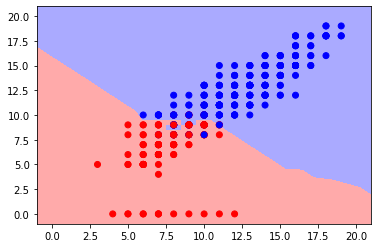

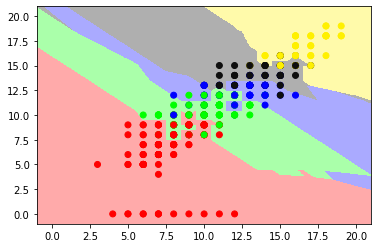

In [35]:
#data re-input
student = pandas.read_csv("student-mat.csv",header=0,delimiter=";")
student = shuffle(student)
student2 = student
student_class=[]
student2_class=[]
for i in range(395):
    if student.iloc[i]["G3"] < 10:
        student_class.append(0) #fail
    else:
        student_class.append(1) #pass
    
    if 0 <= student2.iloc[i]["G3"] <= 9:
        student2_class.append(0) #F
    elif 10 <= student2.iloc[i]["G3"] <= 11:
        student2_class.append(1) #D
    elif 12 <= student2.iloc[i]["G3"] <= 13:
        student2_class.append(2) #C
    elif 14 <= student2.iloc[i]["G3"] <= 15:
        student2_class.append(3) #B
    elif 16 <= student2.iloc[i]["G3"] <= 20:
        student2_class.append(4) #A
    
student_class = np.array(student_class)
student2_class = np.array(student2_class)
#pick two features: G1, G2
student = student.loc[:,["G1","G2"]]
student2 = student
#re-train model (knn)
X_train,X_test,Y_train,Y_test=model_selection.train_test_split(student,student_class,test_size=0.3)
X2_train,X2_test,Y2_train,Y2_test=model_selection.train_test_split(student2,student2_class,test_size=0.3)

print("\nKNN (n=5):")
knn = KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(X_train,Y_train)
prediction_knn = knn.predict(X_test)
print("\nconfusion matrix 1st(2 classes):")
print(confusion_matrix(Y_test, prediction_knn))
kfold_class1(knn)

knn2 = KNeighborsClassifier(n_neighbors=5)
knn2 = knn2.fit(X2_train,Y2_train)
prediction2_knn = knn2.predict(X2_test)
print("\nconfusion matrix 2nd(5 classes):")
print(confusion_matrix(Y2_test, prediction2_knn))
kfold_class2(knn2)

# Plot the decision boundary: class 1
xx, yy = np.meshgrid(np.arange(-1, 21, 0.02),
                     np.arange(-1, 21, 0.02))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Plot also the training points
plt.scatter(student.iloc[:, 0], student.iloc[:, 1], c=student_class, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

# Plot the decision boundary: class 2
xx, yy = np.meshgrid(np.arange(-1, 21, 0.02),
                     np.arange(-1, 21, 0.02))
Z = knn2.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF','#AFAFAF','#FFFAAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#0F0F0F','#FFF000'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Plot also the training points
plt.scatter(student2.iloc[:, 0], student2.iloc[:, 1], c=student2_class, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

上圖紅色為fail,藍色為pass;下圖左下紅色到右上黃色分別為F,D,C,B,A。可以看到預測算是十分準確，除了有少數點預測錯誤(點顏色和背景色不一)。符合上方k-fold的accuracy(約90%,74%)。

In [37]:
X_test=X_test.to_numpy()
one_sample=X_test[0].reshape(1, -1)
print("1-sample (2 classes):")
print(one_sample)
prediction = knn.predict(one_sample)
print("1-sample prediction: ",prediction)


X2_test=X2_test.to_numpy()
one_sample2=X2_test[0].reshape(1, -1)
print("1-sample (5 classes):")
print(one_sample2)
prediction2 = knn2.predict(one_sample2)
print("1-sample prediction: ",prediction2)

1-sample (2 classes):
[[10 13]]
1-sample prediction:  [1]
1-sample (5 classes):
[[18 18]]
1-sample prediction:  [4]


從X_test選一個sample出來train，選到[10 13]，對應上方的圖，可以看到是在藍色區塊，也就是pass(1);
從X2_test一樣選一個，選到[18 18]，對應圖二，可以看到是在最右上方黃色區域，也就是A(4)。